# Config

In [1]:
import os
import types
from typing import Union
from PIL import Image
import string
import fitz
from tqdm import tqdm

In [2]:
# import conversion tools
from conv_tools import *
from conv_tools import tools as ctools
from conv_tools import ter
#from conv_tools import logs
#print(logs)
ctools[('pdf', 'txt')].keys()

Tools converting in the following extensions:
('pdf', 'png')
('png', 'txt')
('pdf', 'txt')
('pdf', 'txt')
('pdf', 'txt')


dict_keys(['PyPDF4_ocr', 'pdfminer_ocr', 'tika_ocr'])

# Load Files

In [3]:
data_path = os.path.join('data')

input_path = os.path.join(data_path, 'input')

# Doc and Converter Classes

A `Doc` class, instantiated once for each document, holding its path, and original/converted data in various formats.

`{format: {tool-name: converted-text}}`

`e.g. {'jpg': {'pdf2txt': <jpg-object>}}`

by using the `to_target_format` method, the document can be converted and stored in another format.


In [4]:
class Doc:
   def __init__(self, input_filepaths, tools):
      self.tools = tools

      # input_filepath is a LIST of filepaths (in case more files belong to the same document)
      self.input_filepaths = input_filepaths
      self.main_input_filepath = input_filepaths[0] # only used to detect filename and extension
      
      self.input_extension = os.path.splitext(self.main_input_filepath)[-1].lower().translate(str.maketrans('', '', string.punctuation))
      self.input_filename = os.path.basename(self.main_input_filepath).lower()
      
      self.txt_conversions = dict() # dict of {tool-name: converted-text} pairs

      self.data = dict() # dict of {target_format: {tool-name: converted-text}} e.g. {'jpg': {'pdf2txt': <jpg-object>}}

   ## doc conversion img<>pdf
   def to_target_format(self, target_format, tool_name = None):
      """target_format can be pdf, png"""
      #selected_tool_name = tool_name
      global selected_tool_name
      
      data_selection = self.data.get(target_format)      
      if data_selection:                           # if at least an instance of (converted/original) data is already stored for given target_format...
         if not tool_name:
            converted_data = data_selection[0]     # ...take the first instance available...
         else:
            converted_data = data_selection[tool_name]  #...unless a preferred conversion tool was selected
         return converted_data
      else: # if the requested extension has no instances, add an empty instance target_format:{}
         self.data[target_format] = dict()
         
      # if requested target_format matches filepath extension, open the document and store it as an object
      if target_format == 'pdf':
         if self.data['pdf']:
            return
         if self.is_pdf():
            # open all files for the given document...
            pdf_objects = []
            for pdf_path in self.input_filepaths:
               with open(pdf_path, 'rb') as file:
                  pdf_objects.append(file)
            converted_data = pdf_objects
            
            self.data[target_format]['original'] = converted_data # ...and store original data in self.data
            
         elif self.is_png(): # if requested target_format does NOT match filepath extension, convert it
            
            tool_selection = self.tools[('png','pdf')] # this gives a dict of suitable tools
            
            if tool_name is None:
               selected_tool_name = list(tool_selection)[0]
               conversion_tool = tool_selection[selected_tool_name] # take first available tool if no tool was specified
            else:
               selected_tool_name=tool_name
               conversion_tool = tool_selection[selected_tool_name] # assign tool based on tool name
                        
            png_objects = None # TODO open files...
            
            converted_data = conversion_tool( # ...apply conversion tool on them...
               png_objects
            )

            self.data[target_format][selected_tool_name] = converted_data # ...and store the converted data
         else:
            print('Error: source format {0} is nor accepted'.format(self.input_extension))
            return
      
      # if requested target_format matches filepath extension, open the document and store it as an object
      elif target_format == "png":
         if self.data['png']:
            return
         if self.is_png():   
            # open all files for the given document...
            converted_data = [
               Image.open(image_path) for image_path in self.input_filepaths
               ]
               
            self.data[target_format]['original'] = converted_data # ... and store original data in self.data

         elif self.is_pdf():
            tool_selection = self.tools[('pdf','png')] # this gives a dict of suitable tools
            if tool_name is None:
               selected_tool_name = list(tool_selection)[0]
               conversion_tool = tool_selection[selected_tool_name] # take first available tool if no tool was specified
            else:
               selected_tool_name=tool_name
               conversion_tool = tool_selection[selected_tool_name] # assign tool based on tool name
                        
            pdf_filepath = [ # open files...
               path for path in self.input_filepaths if path.endswith('.pdf')
            ][0]
            
            converted_data = conversion_tool( # ...apply conversion tool on them...
               pdf_filepath
            )
            self.data[target_format][selected_tool_name] = converted_data # ...and store the converted data
            
            #print('self.data[{0}][{1}]:{2}'.format(target_format,selected_tool_name,self.data[target_format][selected_tool_name]))
            
         else:
            #print('Error: source format {0} is nor accepted'.format(self.input_extension))
            return
      else:
         #print('Error: target_format {0} is nor accepted'.format(target_format))
         return
      
      #print('self.data[{0}][{1}]:{2}'.format(target_format,selected_tool_name,self.data[target_format][selected_tool_name]))
      return 
      
   ## check extension
   def is_pdf(self):
      return self.input_extension.lower() == 'pdf'
   def is_png(self):
      return self.input_extension.lower() == 'png'

   ## save output txt
   def save_txt_conversion(self, tool_name, doc_path):
      # define output filepath
      output_file_path = os.path.join(doc_path,tool_name,str(self.input_filename)+'.txt')

      # save txt in chosen dir
      os.makedirs(os.path.dirname(output_file_path), exist_ok=True)
      with open(output_file_path, 'w+') as f:
         f.write(self.txt_conversions[tool_name])
   
   def save_all_txt_conversions(self, doc_path):
      for key in self.txt_conversions.keys():
         self.save_txt_conversion(key, doc_path)

In [5]:
class TxtConverter:
   def __init__(self, tools):
      #self.available_functions = {str(f):f for f in globals().values() if type(f) == types.FunctionType}
      self.tools = tools
      
   # select tool and convert
   def convert_to_txt(self, doc, input_formats=['pdf','png'], tool_names = None):

      output_format = 'txt'
      tool_selection = {}
      for input_format in input_formats:
         tool_selection.update(self.tools[(input_format, output_format)]) # this adds tools given the required formats
      if isinstance(tool_names, str):
         tool_names = [tool_names]

      if tool_names is None: # use all the conversion tools
         tool_names = tool_selection.keys()
      
      print('tool_selection.keys()',tool_selection.keys())
      print('tool_names',tool_names)
      selected_tools = {}
      for tool_name in tool_names:
         selected_tools[tool_name] = tool_selection[tool_name]

      extracted_texts = dict()
      for t_name in tqdm(tool_names):
         req_ext = ter[t_name]      # extract input format of tool
         doc_ext = doc.data[req_ext]
         #TODO: if doc_ext is empty: convert
         
         first_tool_name = list(doc_ext.keys())[0]
         pdf_filepath = doc.main_input_filepath      # get path from doc # TODO: trat multiple pdfs per document
         extracted_texts[t_name]= selected_tools[t_name](pdf_filepath)  # pass it to tool

      #store in doc.txt_conversions
      doc.txt_conversions.update(extracted_texts) # join the dictionaires
      
      # store in doc.data
      if not doc.data.get('txt'):
         doc.data['txt'] = dict()
      
      doc.data['txt'].update(extracted_texts) # join the dictionaires

# Conversion and Evaluation

In [6]:
import fastwer

OKCYAN = '\033[96m'
ENDC = '\033[0m'

In [7]:
# create convertor instance from class
converter = TxtConverter(tools=ctools)

In [8]:
# for doc in data (each doc has its own directory)
print(OKCYAN + 'Input_path:', input_path + ENDC) 
cers = {} # CER scores

for dir in os.listdir(input_path):
    dir_path = os.path.join(input_path,dir)
    doc_paths = [os.path.join(dir_path, filepath) for filepath in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, filepath))]
    # create Doc instance with doc path
    doc_object = Doc(doc_paths, tools=ctools)
    print(OKCYAN + 'Converting:', dir_path + ENDC)

    ##############
    # CONVERSION #
    ##############
      
    # convert to jpg/pdf
    doc_object.to_target_format('png', tool_name='pdf2img')
    doc_object.to_target_format('pdf')
    print(doc_object.data['pdf'])
    
    # convert to txt it with all tools
    converter.convert_to_txt(doc_object, tool_names=['pytesseract_ocr','tika_ocr','pdfminer_ocr','PyPDF4_ocr'])

    # save all
    doc_object.save_all_txt_conversions(dir_path)

    ##############
    # EVALUATION #
    ##############

    name = doc_object.input_filename
    cers[name] = {}
    
    for tool_name,text in doc_object.data['txt'].items():
        ref = os.listdir(os.path.join(dir_path,'ref'))[0]
        output = text
        score = fastwer.score_sent(output, ref, char_level=True)
        cers[name][tool_name] = score

print(OKCYAN , 'Character Error Rates', cers , ENDC)

Input_path: data/input
Converting: data/input/flyer_coleottero_giapponese
{'original': [<_io.BufferedReader name='data/input/flyer_coleottero_giapponese/flyer_coleottero_giappone_zone_misure.pdf'>]}
tool_selection.keys() dict_keys(['PyPDF4_ocr', 'pdfminer_ocr', 'tika_ocr', 'pytesseract_ocr'])
tool_names ['pytesseract_ocr', 'tika_ocr', 'pdfminer_ocr', 'PyPDF4_ocr']


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


2
Converting: data/input/sample
{'original': [<_io.BufferedReader name='data/input/sample/sample_no_txt.pdf'>]}
tool_selection.keys() dict_keys(['PyPDF4_ocr', 'pdfminer_ocr', 'tika_ocr', 'pytesseract_ocr'])
tool_names ['pytesseract_ocr', 'tika_ocr', 'pdfminer_ocr', 'PyPDF4_ocr']


100%|██████████| 4/4 [01:41<00:00, 25.46s/it]

17
 Character Error Rates {'flyer_coleottero_giappone_zone_misure.pdf': {'pytesseract_ocr': 12096.0, 'tika_ocr': 21844.0, 'pdfminer_ocr': 21128.0, 'PyPDF4_ocr': 8032.0}, 'sample_no_txt.pdf': {'pytesseract_ocr': 24385.7143, 'tika_ocr': 625078.5714, 'pdfminer_ocr': 683714.2857, 'PyPDF4_ocr': 100.0}} 


# Visualisation

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# sum up scores per tools
cer_per_tool = {}

for _,tool_cer in cers.items():
    for tool,cer in tool_cer.items():
        cer_per_tool[tool] = 0
        print(tool)    
    break
        
for _,tool_cer in cers.items():
    for tool,cer in tool_cer.items():
        cer_per_tool[tool] = cer_per_tool[tool]+cer

cer_per_tool

pytesseract_ocr
tika_ocr
pdfminer_ocr
PyPDF4_ocr


{'pytesseract_ocr': 36481.7143,
 'tika_ocr': 646922.5714,
 'pdfminer_ocr': 704842.2857,
 'PyPDF4_ocr': 8132.0}

In [11]:
data = cer_per_tool

<AxesSubplot:>

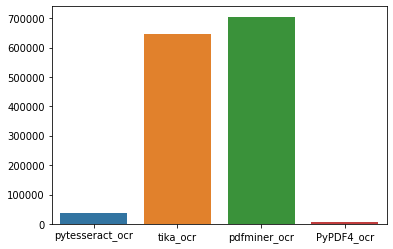

In [12]:
sns.barplot(x=list(data.keys()), y=list(data.values()))